# **Credit Card Churn Prediction**
By Ugochi Ugbomeh
- Original Dataset from Kaggle https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?resource=download

Churn, also known as customer attrition, refers to when a customer stops doing business with a company. In the context of this project, churn represents credit card customers who have either closed their account or become inactive. This notebook focuses on analysing and predicting churn using the Credit Card Customer dataset. By identifying the key behaviours and attributes associated with churned customers, we aim to help businesses:

**Understand why customers leave**

- Take proactive steps to retain at-risk customers
- Improve long-term customer loyalty and revenue
- Predicting churn accurately allows businesses to make data-driven decisions that prioritise customer retention — which is often more cost-effective than acquiring new customers.

In [1]:
!pip install xgboost
!pip install shap


In [9]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Optional: for clean visuals
sns.set(style='whitegrid')
import pprint
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import shap
import joblib
from flask import Flask, request, jsonify
import requests
import json

## **Loading dataset** 


In [11]:
bchurners = pd.read_csv("BankChurners.csv")
# Preview data
bchurners.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [13]:
bchurners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [15]:
bchurners.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


In [17]:
bchurners.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [19]:
bchurners.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

## **Dataset Summary**
- Total Records: 10,127 customers
- Total Columns: 23 (including ID, demographics, account activity, and model outputs)
- Missing Values: None
- Target Variable: Attrition_Flag
- Attrited Customer = churned
- Existing Customer = retained

------------------------------
**Customer Demographics**
- Customer_Age: Ranges from 26 to 73 years
- Gender: Male/Female
- Dependent_count: Between 0 and 5

-------------------------------
**Account Information**
- Months_on_book: Customer tenure in months (13–56)
- Credit_Limit: Ranges from USD1,438 to USD34,516
- Avg_Utilization_Ratio: Credit usage (0.0 to 1.0)

---------------------------------------

**Activity & Transaction Behaviour**
- Total_Trans_Ct: Transaction count (10–139)
- Total_Trans_Amt: Transaction value (USD510–USD18,484)
- Total_Amt_Chng_Q4_Q1: Change in amount from Q4 to Q1
- Total_Ct_Chng_Q4_Q1: Change in transaction count
- Months_Inactive_12_mon: Inactivity over last year (0–6)

------------------------------------------
**Categorical Variables**
- Education_Level, Income_Category, Marital_Status, Card_Category
- All appear to be clean and well-distributed ( data had already been cleaned from previous researcher on Kaggle)

--------------
**Auto-generated Features**
Two long columns beginning with Naive_Bayes_Classifier_...
— likely machine-generated probabilities from an internal model by previous researcher to be deleted.


## **Cleaning and Transformation**



In [23]:
#Dropping irrelevant Columns
bchurners.drop(columns=[
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
], inplace=True)

In [25]:
bchurners.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

### Encode the Attrition_Flag into a binary Churn column

In [28]:
#1 for Attrited Customer and 0 for Existing Customer
bchurners['Churn'] = bchurners['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)
# Drop the Attrition Flag Column
bchurners.drop(columns='Attrition_Flag', inplace=True)
bchurners.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn'],
      dtype='object')

### Categorical Variables

In [31]:
bchurners.select_dtypes(include='object').columns


Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [33]:
#one-hot encode categorical variablest to remove bias and prepare for Exploratory data analysis and Modelling
bchurners_encoded = pd.get_dummies(bchurners, drop_first=True)


In [35]:
bchurners_encoded.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,False,False,False,True,False,False,False,False,False,False
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,True,False,False,False,False,True,False,False,False,False
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,False,False,False,False,True,False,False,False,False,False
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,False,True,False,False,False,True,False,False,False,False
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,False,False,False,True,False,False,False,False,False,False


In [37]:
#Create Label Maps for Each Categorical Column | This is for my power BI interactive dashboard later on
# Create empty dictionary to store mappings
encoding_maps = {}

# Loop through all object-type columns
for col in bchurners.select_dtypes(include='object').columns:
    unique_vals = bchurners[col].unique().tolist()
    encoding_maps[col] = unique_vals

# Preview the dictionary as nested list
for key, val in encoding_maps.items():
    print(f"{key}: {val}")


Gender: ['M', 'F']
Education_Level: ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Marital_Status: ['Married', 'Single', 'Unknown', 'Divorced']
Income_Category: ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown']
Card_Category: ['Blue', 'Gold', 'Silver', 'Platinum']


In [39]:
bchurners_encoded = pd.get_dummies(bchurners, drop_first=True)


In [41]:
pprint.pprint(encoding_maps)

{'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum'],
 'Education_Level': ['High School',
                     'Graduate',
                     'Uneducated',
                     'Unknown',
                     'College',
                     'Post-Graduate',
                     'Doctorate'],
 'Gender': ['M', 'F'],
 'Income_Category': ['$60K - $80K',
                     'Less than $40K',
                     '$80K - $120K',
                     '$40K - $60K',
                     '$120K +',
                     'Unknown'],
 'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced']}


In [42]:
#export map as CSV for later
# Flatten the dictionary to a list of records
mapping_list = []
for col, values in encoding_maps.items():
    for val in values:
        mapping_list.append({'Column': col, 'Original Value': val})

# Convert to DataFrame and save
import pandas as pd
mapping_df = pd.DataFrame(mapping_list)
mapping_df.to_csv('categorical_value_mappings.csv', index=False)


## **Exploratory Data Analysis - EDA**

### **Churn Distribution**
- Goal: To understand the balance of churned vs. retained customers.

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\3173083883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=bchurners_encoded.astype({'Churn': 'str'}), palette=palette)


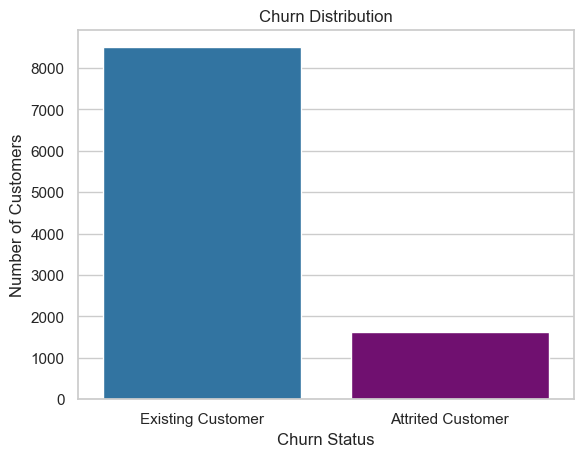

In [47]:
palette = {'0': "#1f77b4", '1': "#800080"}  # blue & purple for string values

sns.countplot(x='Churn', data=bchurners_encoded.astype({'Churn': 'str'}), palette=palette)
plt.title('Churn Distribution')
plt.xticks([0, 1], ['Existing Customer', 'Attrited Customer'])
plt.ylabel('Number of Customers')
plt.xlabel('Churn Status')
plt.show()


There is definitley some class imbalace as the Existing Customer dominates the Attrited Customer

----------------------------------------------------------------------------------

### **Compare Numerical Variables by Churn**

Numerical variables represent measurable customer behaviours — such as transaction count, credit limit, or account age. Comparing these variables against churn helps us uncover patterns in customer engagement and risk.

> **"Do customers who churn behave differently in terms of spending, activity, or account usage?"**

#### What We’re Looking For
- **Low engagement** indicators (e.g., low transaction count, low utilisation)
- **Account tenure or credit behaviours** that differ between churned and retained customers
- **Outliers or usage extremes** that could signal churn risk

#### Why It Matters
Analysing numerical variables by churn helps:
- Identify the strongest behavioural predictors of churn
- Inform modelling decisions (e.g., which variables to prioritise)
- Support data-driven retention strategies (e.g., encourage higher usage among low-transacting users)

I choseb boxplots because they are used here to visualise differences in distribution, median values, and presence of outliers across churn classes.

### **Total Transaction Count vs Churn**
Why: High activity = likely retained; low activity = potential churn

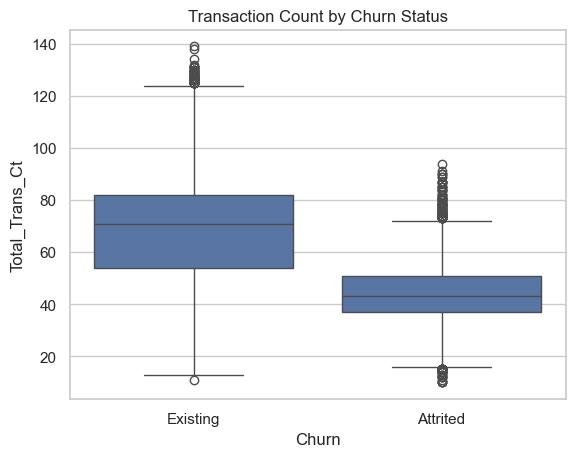

In [51]:
sns.boxplot(x='Churn', y='Total_Trans_Ct', data=bchurners_encoded)
plt.title('Transaction Count by Churn Status')
plt.xticks([0, 1], ['Existing', 'Attrited'])
plt.show()

There are clear outliers on both sides, especially among Existing Customers with very high Total_Trans_Ct.
- Median transaction count is significantly higher for non-churned customers.
- Attrited customers tend to have lower and more concentrated transaction counts.
- A few power users exist among retained customers — they likely skew averages.

In [54]:
numerical_cols = bchurners_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Churn')  # Remove target
numerical_cols

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\586152830.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Existing', 'Attrited'])
C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\586152830.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Existing', 'Attrited'])
C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\586152830.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Existing', 'Attrited'])
C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\586152830.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Existing', 'Attrited'])
C:\Users\goc

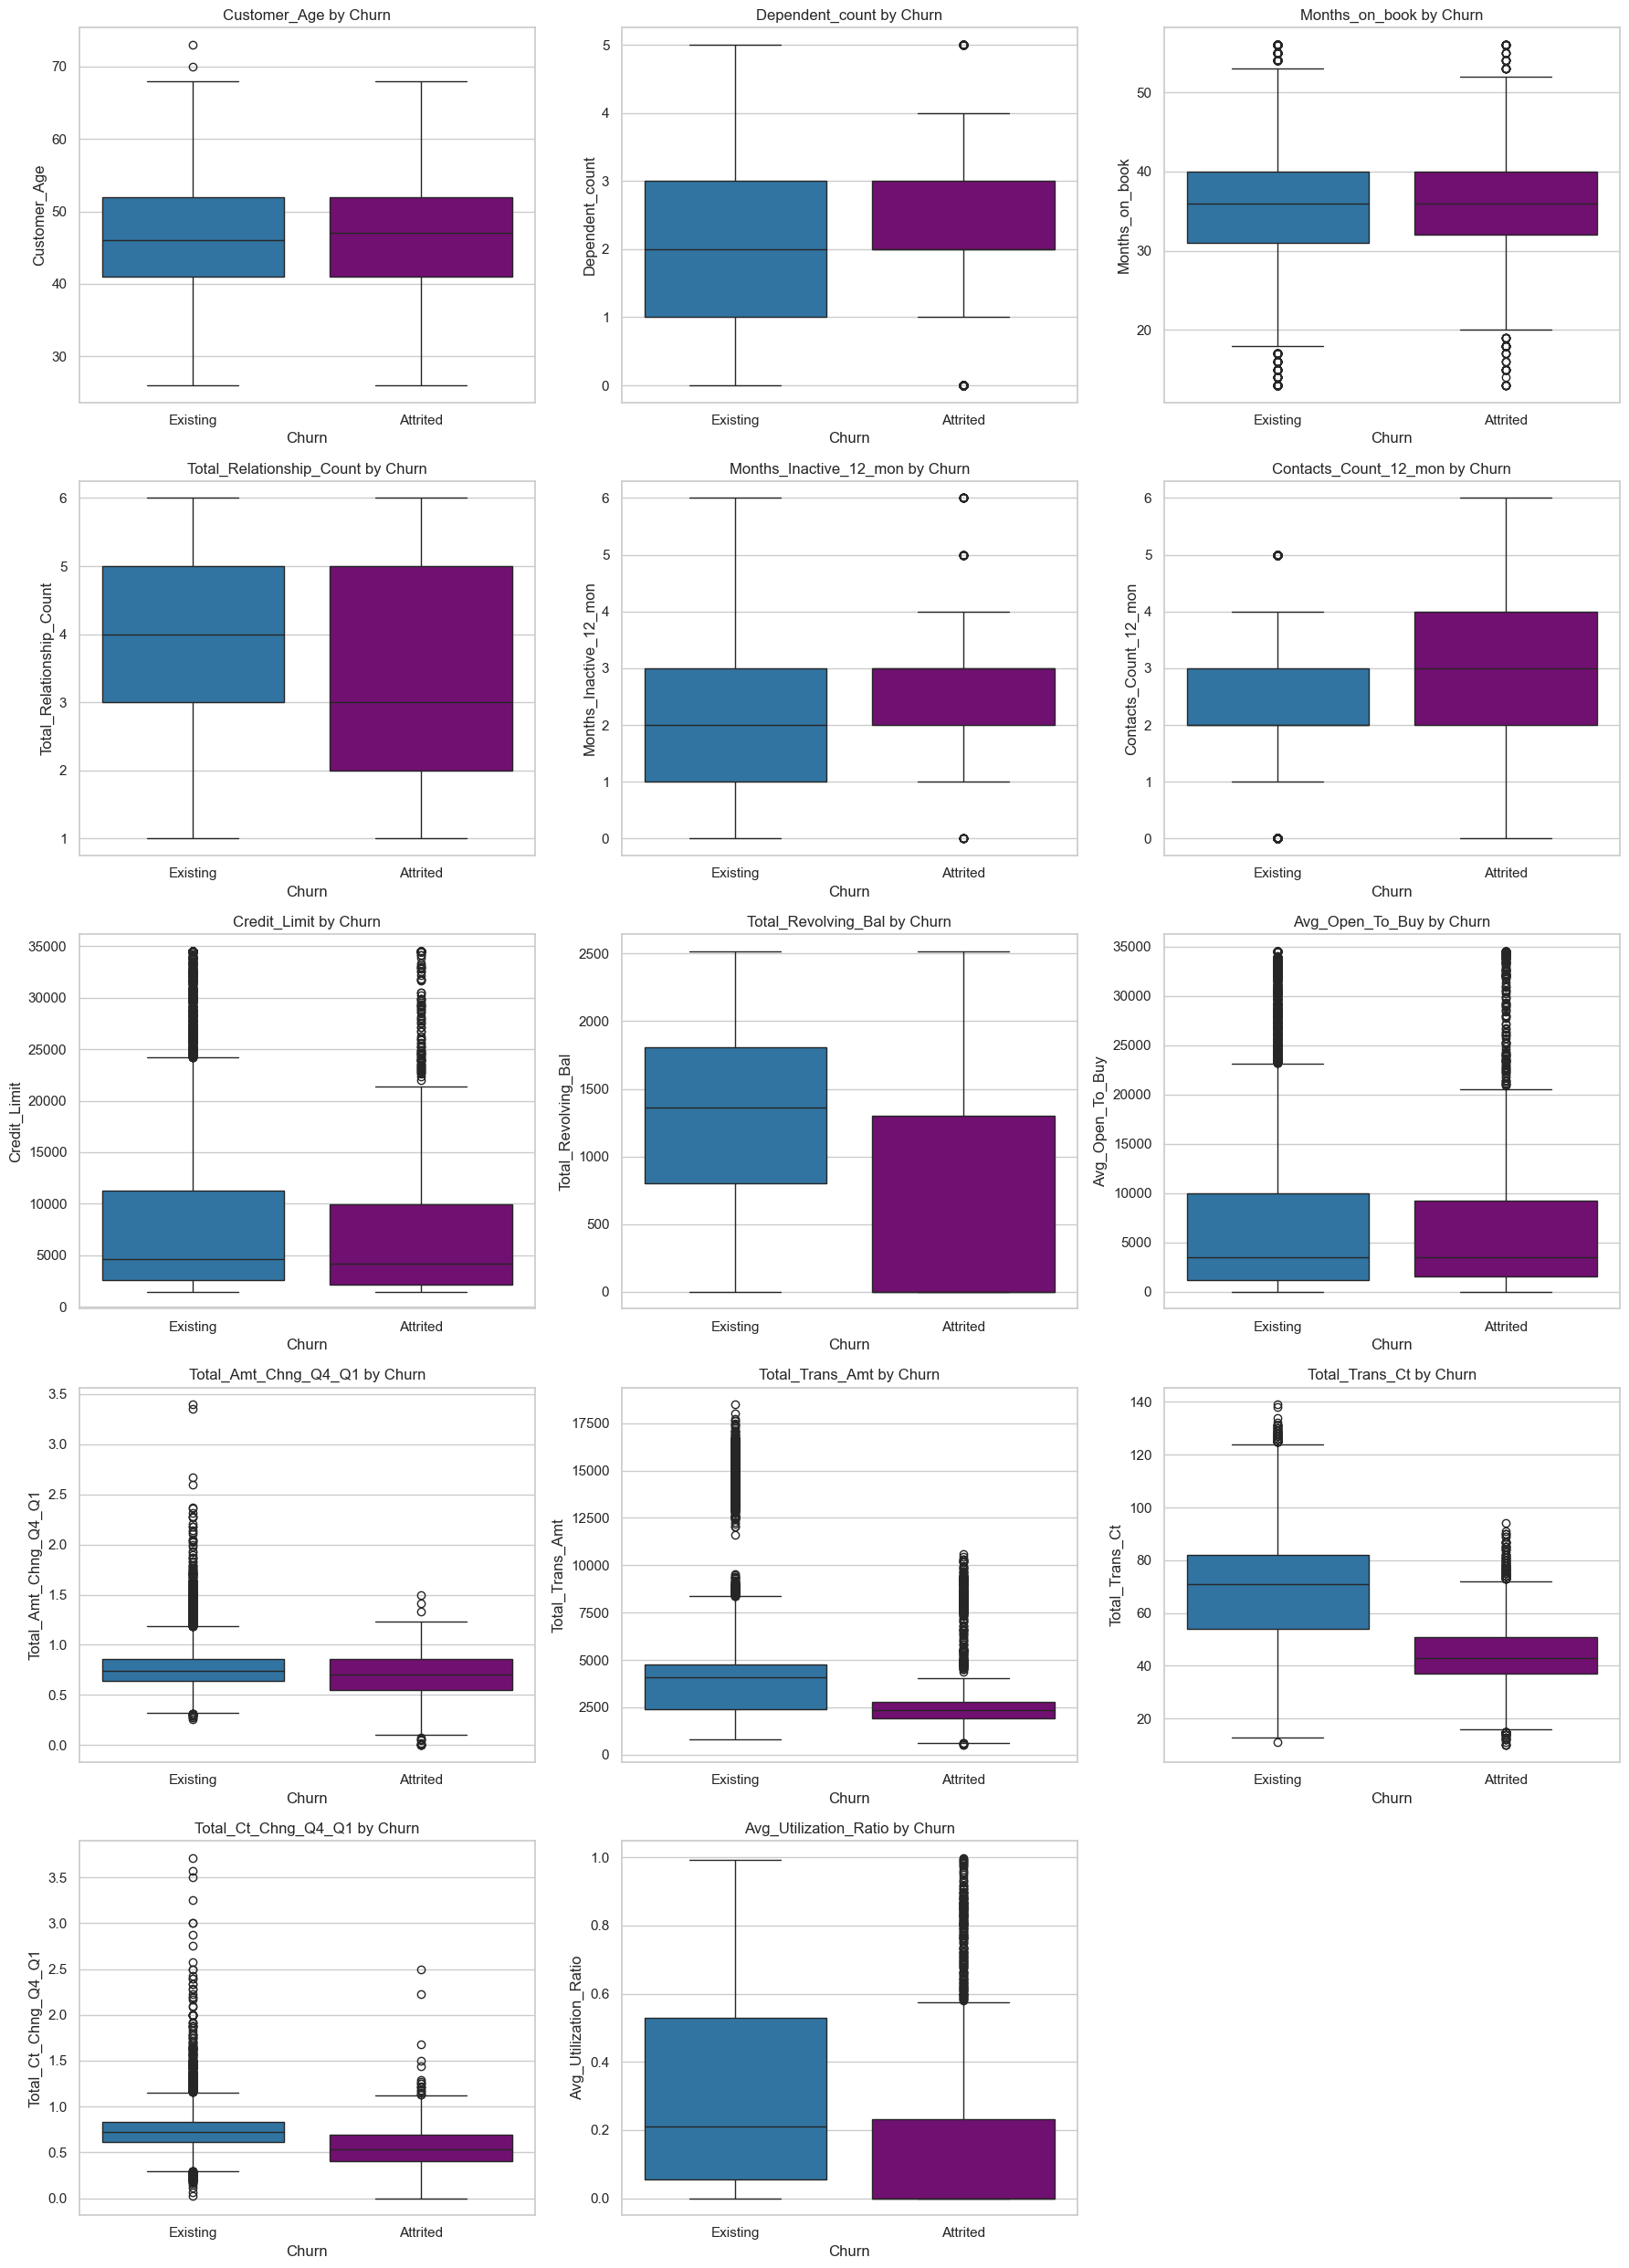

In [57]:
# List of numerical columns to plot
numerical_cols = bchurners_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Churn')  # Exclude target

# Number of plots
n = len(numerical_cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

# Set up the figure
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 5))
axes = axes.flatten()  # Flatten in case of multiple rows

# Custom palette
palette = {0: "#1f77b4", 1: "#800080"}

# Plot each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Churn', y=col, hue='Churn', data=bchurners_encoded,
                palette=palette, legend=False, ax=axes[i])
    axes[i].set_title(f'{col} by Churn')
    axes[i].set_xticklabels(['Existing', 'Attrited'])

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout adjustment
plt.tight_layout()
plt.show()

### **Numerical Features by Churn – Discussion**

This section explores how various numerical variables differ between **existing** and **churned (attrited)** customers using boxplots. The aim is to identify patterns in behaviour and engagement that may be predictive of churn.

---

####  Customer Demographics & Account Attributes

- **Customer Age:** The median age of churned customers is slightly lower than that of retained ones, though the interquartile ranges (IQRs) are similar. There are several high-age outliers among retained customers, indicating that older individuals tend to stay longer.

- **Dependent Count:** Both churned and existing customers show a similar range and distribution. No major deviation in median or spread, suggesting this variable may have limited predictive power on its own.

- **Months on Book (Tenure):** Existing customers generally have a slightly longer tenure. The median is slightly higher and the IQR is shifted to the right. Churned customers cluster more around the lower end of tenure, supporting the idea that **newer customers are more likely to leave**.

- **Total Relationship Count:** Similar medians but slightly more spread among existing customers. No clear separation, but lower relationship counts among some churned customers could signal disengagement.

- **Months Inactive in Last 12 Months:** Churned customers are visibly more inactive, with a higher median and more outliers beyond 5–6 months. This suggests **inactivity is a strong churn signal**.

- **Contacts with Bank (Last 12 Months):** Attrited customers have a slightly higher number of contacts on average. The presence of outliers (frequent contacts) may reflect frustration, complaints, or unresolved issues.

---

####  Transaction and Spending Behaviour

- **Total Transaction Amount & Total Transaction Count:** These are among the clearest differentiators. Churned customers show significantly **lower medians**, **tighter IQRs**, and fewer high-value outliers. This strongly suggests that **low engagement or spending behaviour precedes churn**.

- **Total Amount Change (Q4 to Q1):** Churned customers display less variation and a slightly lower median, implying that their spending behaviour is **less dynamic** or already declining before they leave. A few outliers indicate some churners still had notable spending shifts.

- **Total Count Change (Q4 to Q1):** Again, churned customers appear less variable and slightly lower in median count change. A concentration around the lower end of the range indicates **reduced activity over time**.

- **Average Utilisation Ratio:** Churned customers have a lower median utilisation rate. The box is tighter, showing less variability. Existing customers have a wider range and many high outliers, implying they are more active and possibly rely more heavily on their credit, which may contribute to loyalty.

---

####  Outliers

Numerous outliers are observed across features like:
- `Customer_Age` (elderly retained customers)
- `Total_Trans_Amt` and `Total_Trans_Ct` (high-spending retained users)
- `Avg_Utilization_Ratio` (some customers use nearly all available credit)

These outliers likely represent **high-value or high-risk segments** and will treated carefully in modelling capping to avoid or reduce skewing results.

---

#### Summary Insights

- The strongest predictors of churn based on visual separation are:  
  `Total_Trans_Ct`, `Total_Trans_Amt`, `Avg_Utilization_Ratio`, `Months_Inactive_12_mon`, and `Months_on_book`.

- Features with minimal difference between churn classes (e.g., `Dependent_count`, `Total_Relationship_Count`) may still have value when used in interaction with others.

- Outliers provide important business context (e.g., VIPs, inactive but high-limit users) and will be preserved for interpretation in Power BI but treated with domain-specific thresholds when modelling.


In [59]:
#To support the boxplots above
# Grouped summary statistics (mean, median, std) by churn
summary_stats = bchurners_encoded.groupby('Churn')[numerical_cols].agg(['mean', 'median', 'std']).T

# Optional: rename columns for clarity (if churn is 0 = Existing, 1 = Attrited)
summary_stats.columns = ['Existing', 'Attrited']

# Display all stats neatly
summary_stats


Existing     Attrited
Customer_Age             mean      46.262118    46.659496
                         median    46.000000    47.000000
                         std        8.081157     7.665652
Dependent_count          mean       2.335412     2.402581
                         median     2.000000     2.000000
                         std        1.303229     1.275010
Months_on_book           mean      35.880588    36.178242
                         median    36.000000    36.000000
                         std        8.021810     7.796548
Total_Relationship_Count mean       3.914588     3.279656
                         median     4.000000     3.000000
                         std        1.528949     1.577782
Months_Inactive_12_mon   mean       2.273765     2.693301
                         median     2.000000     3.000000
                         std        1.016741     0.899623
Contacts_Count_12_mon    mean       2.356353     2.972342
                         median     2.000000     3.000000
                         std        1.081436     1.090537
Credit_Limit             mean    8726.877518  8136.039459
                         median  4643.500000  4178.000000
                         std     9084.969807  9095.334105
Total_Revolving_Bal      mean    1256.604118   672.822987
                         median  1364.000000     0.000000
                         std      757.745354   921.385582
Avg_Open_To_Buy          mean    7470.273400  7463.216472
                         median  3469.500000  3488.000000
                         std     9087.671862  9109.208129
Total_Amt_Chng_Q4_Q1     mean       0.772510     0.694277
                         median     0.743000     0.701000
                         std        0.217783     0.214924
Total_Trans_Amt          mean    4654.655882  3095.025814
                         median  4100.000000  2329.000000
                         std     3512.772635  2308.227629
Total_Trans_Ct           mean      68.672588    44.933620
                         median    71.000000    43.000000
                         std       22.919011    14.568429
Total_Ct_Chng_Q4_Q1      mean       0.742434     0.554386
                         median     0.721000     0.531000
                         std        0.228054     0.226854
Avg_Utilization_Ratio    mean       0.296412     0.162475
                         median     0.211000     0.000000
                         std        0.272568     0.264458

### **Tenure Group**

`Tenure_Group` feature from the `Months_on_book` column to better capture how customer tenure influences churn. Grouping customers into tenure segments (e.g., 0–12 months, 13–24 months, etc.) allows us to:

- Identify non-linear patterns in churn that may not be apparent when using a continuous numeric variable.
- Improve interpretability by segmenting customers into easily understandable categories for business stakeholders.
- Enhance visual storytelling in dashboards, making it simpler to compare churn rates across different customer tenure groups.

In short, this feature helps gain clearer insights into customer behavior and design more targeted retention strategies.

In [62]:
# Create tenure buckets based on dataset distribution
bchurners['Tenure_Group'] = pd.cut(
    bchurners['Months_on_book'],
    bins=[12, 24, 36, 48, 60],  # Ends at 60 instead of 72
    labels=['13–24', '25–36', '37–48', '49–60'],
    right=True
)
#Check Value Counts
bchurners['Tenure_Group'].value_counts().sort_index()


Tenure_Group
13–24     847
25–36    5418
37–48    3207
49–60     655
Name: count, dtype: int64

### **Checking churn rate by tenure group** 

In [64]:
churn_rate_by_tenure = bchurners.groupby('Tenure_Group')['Churn'].mean() * 100
churn_rate_by_tenure


C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\1989020324.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_tenure = bchurners.groupby('Tenure_Group')['Churn'].mean() * 100


Tenure_Group
13–24    14.876033
25–36    16.076043
37–48    16.183349
49–60    16.946565
Name: Churn, dtype: float64

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\3178967887.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_tenure.index, y=churn_rate_by_tenure.values, palette="Purples_d")


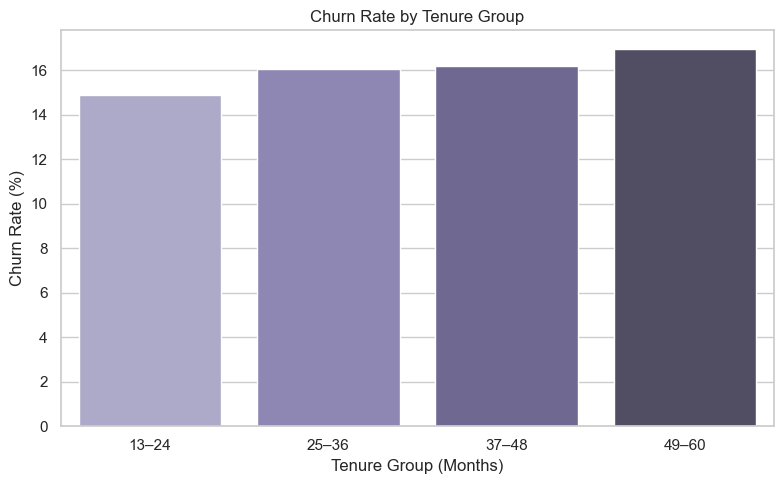

In [69]:
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_rate_by_tenure.index, y=churn_rate_by_tenure.values, palette="Purples_d")
plt.title('Churn Rate by Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure Group (Months)')
plt.tight_layout()
plt.show()

#### Churn Rate by Tenure Group – Discussion

- The churn rate varies slightly across the different tenure groups and shows a **gradual upward trend**:
- This indicates that customers who have been on book for longer periods are **slightly more likely to churn**. While the differences aren't extreme, the trend suggests that **longer-tenured customers may become less engaged or satisfied over time**.

Including `Tenure_Group` as a categorical feature helps:
- Segment churn risk by customer lifecycle stage
- Improve interpretability for stakeholders
- Potentially enhance model performance by capturing non-linear tenure effects

-----------------------------------------------------------------------------------------

### **Compare Categorical Variables by Churn**

When analysing churn, it's important to explore how categorical features (like `Gender`, `Income_Category`, or `Card_Category`) relate to customer attrition. These comparisons help us answer:

> **"Are certain groups of customers more likely to churn than others?"**

#### What We’re Looking For
- **Patterns** – e.g., customers with premium cards churn more or less
- **Imbalances** – certain groups may have significantly higher churn
- **Opportunities** – identify high-risk segments to target with retention efforts

#### Why This Matters
Understanding churn by demographic or behavioural segments enables the business to:
- Tailor retention strategies to at-risk groups
- Create more effective and personalised customer experiences
- Prioritise intervention for segments with high churn potential

These insights also feed directly into any interactive dashboard, making it easy for stakeholders to visualise who is churning and where to focus.

### **Card Category vs Churn**
> Why We Care = Do premium cardholders (e.g., Gold, Platinum) churn more or less?

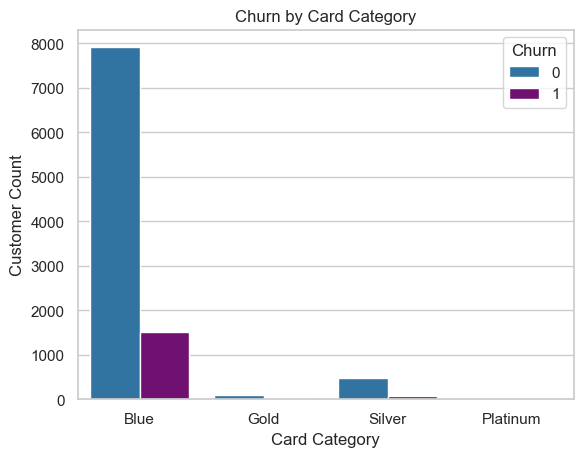

In [74]:
sns.countplot(x='Card_Category', hue='Churn', data=bchurners, palette={0: "#1f77b4", 1: "#800080"})
plt.title('Churn by Card Category')
plt.ylabel('Customer Count')
plt.xlabel('Card Category')
plt.show()


The Blue Card is by far the most dominant card type in the dataset, with the vast majority of customers—both churned and retained—belonging to this group. As a result, most of the observed churn also comes from Blue cardholders. However, this is likely a reflection of the group’s large population rather than an indication of higher churn risk. In contrast, the Gold, Silver, and Platinum card categories have significantly fewer customers overall, and as expected, show minimal churn activity. This low churn may not necessarily point to greater loyalty, but rather to the small sample sizes within these groups. Notably, Platinum cardholders show no churn at all in the dataset, which could either indicate exceptional engagement or simply reflect the fact that there are very few of them. Because the Blue card group so heavily dominates the population, raw churn counts can be misleading. To gain more meaningful insights, it’s important to calculate and compare the churn rate within each card category rather than relying on absolute numbers alone.

In [76]:
#calculate churn rate (%) by card type to uncover:
#“Which card has the highest proportion of churn among its users?”
churn_rate_by_card = bchurners.groupby('Card_Category')['Churn'].mean().sort_values(ascending=False) * 100
churn_rate_by_card


Card_Category
Platinum    25.000000
Gold        18.103448
Blue        16.097923
Silver      14.774775
Name: Churn, dtype: float64

### **Churn Rate by Card Category (Bar Chart)**

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\3528258342.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_card.values, y=churn_rate_by_card.index, palette="Purples_d")


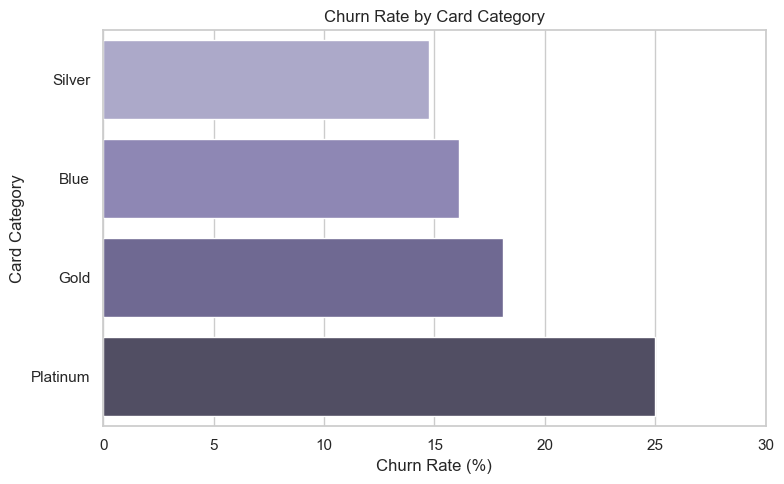

In [78]:
# Calculate churn rate (%) by card category
churn_rate_by_card = bchurners.groupby('Card_Category')['Churn'].mean().sort_values(ascending=True) * 100

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_rate_by_card.values, y=churn_rate_by_card.index, palette="Purples_d")
plt.title("Churn Rate by Card Category")
plt.xlabel("Churn Rate (%)")
plt.ylabel("Card Category")
plt.xlim(0, churn_rate_by_card.max() + 5)
plt.tight_layout()
plt.show()


Platinum cardholders exhibit the highest churn rate, at around 25%. However, this figure is likely based on a very small number of customers. These individuals may represent VIP users with higher expectations, meaning even minor service issues could lead to attrition. Gold and Blue cardholders show moderate churn rates, approximately 17% to 18%. While the Blue card is by far the most common among customers, its churn risk remains notable, suggesting that high volume does not necessarily equate to customer satisfaction or loyalty. In contrast, Silver cardholders have the lowest churn rate, at around 14.5%, which may indicate that this tier strikes a balance in terms of perceived value, benefits, and overall customer experience.


-------------------------------------------------------------------------------

### **Income Category vs Churn**
> Why we care = Are high or low-income groups more likely to leave?

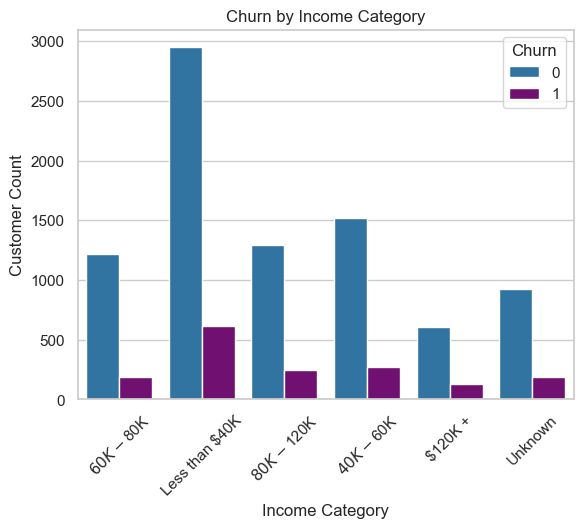

In [83]:
sns.countplot(x='Income_Category', hue='Churn', data=bchurners, palette={0: "#1f77b4", 1: "#800080"})
plt.title('Churn by Income Category')
plt.ylabel('Customer Count')
plt.xlabel('Income Category')
plt.xticks(rotation=45)
plt.show()

Customers earning less than USD40K have the highest churn count in absolute terms. However, they also make up the largest portion of the overall customer base, so this high churn volume may simply reflect their population size rather than a higher risk of churn. On the other end of the spectrum, customers in the USD120K+ income group show the lowest number of churn cases, which may indicate greater loyalty, higher satisfaction, or a better experience due to more personalised services.

The "Unknown" income category also shows some churn activity. At this stage, it's unclear whether these customers behave more like low-income or high-income groups. Depending on further exploration, this group could either be retained as-is, merged with a similar category such as "Less than $40K", or removed entirely if it proves to be too inconsistent or noisy.

### **Education Level vs Churn**
> Does education level correlate with loyalty or dissatisfaction?

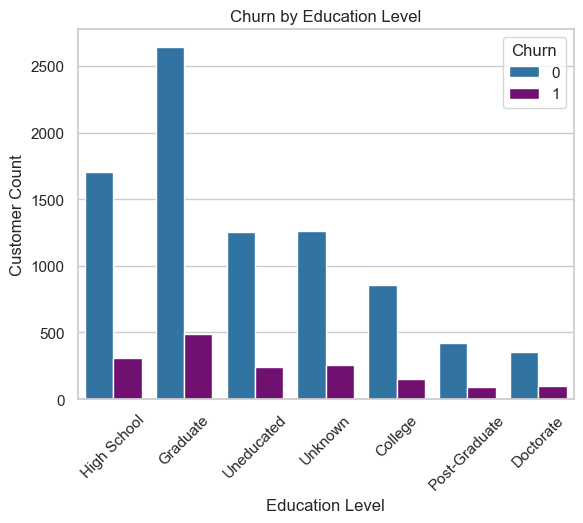

In [87]:
sns.countplot(x='Education_Level', hue='Churn', data=bchurners, palette={0: "#1f77b4", 1: "#800080"})
plt.title('Churn by Education Level')
plt.ylabel('Customer Count')
plt.xlabel('Education Level')
plt.xticks(rotation=45)
plt.show()

Graduate customers represent the largest group overall, and also account for the highest absolute number of churned customers. However, this could simply reflect their large population size rather than a higher churn rate. Customers with a High School education, those classified as Uneducated, and those whose education level is Unknown all show relatively similar churn volumes. This suggests that churn is not disproportionately concentrated among the least educated customers, as one might assume. Interestingly, customers with College, Post-Graduate, and Doctorate degrees exhibit noticeably fewer churn cases, though these groups are also much smaller in number. This pattern could be a result of greater satisfaction, higher financial literacy, or simply a reflection of the smaller presence of highly educated customers in the overall dataset.

Education level does not appear to follow a straightforward relationship with churn. For example, churn is not highest among the least educated, nor is it lowest among the most educated. The “Unknown” education group shows a moderate level of churn and could warrant further investigation — such as exploring whether these customers have specific traits like lower credit limits or particular card categories. For modelling purposes, it may also be helpful to consider combining smaller categories like “Post-Graduate” and “Doctorate” to reduce potential noise from sparse classes.

### **Marital Status vs Churn**
> Can marital status signal stability or churn risk?

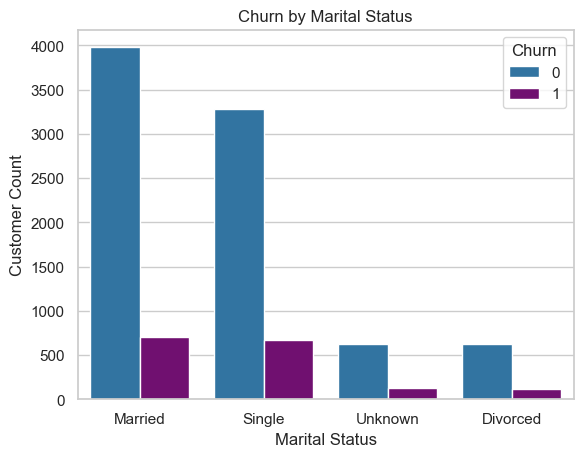

In [91]:
sns.countplot(x='Marital_Status', hue='Churn', data=bchurners, palette={0: "#1f77b4", 1: "#800080"})
plt.title('Churn by Marital Status')
plt.ylabel('Customer Count')
plt.xlabel('Marital Status')
plt.show()

The chart shows that the largest customer segments are those who are married and single, with married individuals slightly more dominant. In terms of churn, both married and single customers account for the highest absolute number of attrited customers. However, since these groups are also the most populous overall, their higher churn counts may be driven by their size rather than by a heightened risk of attrition.

Customers whose marital status is listed as "Unknown" or "Divorced" make up much smaller portions of the customer base. These groups also show relatively low churn counts. Interestingly, churn appears to be slightly lower in these categories, though this might not be statistically significant due to the smaller sample sizes.

From a modelling or retention perspective, marital status may not be a strong predictor of churn on its own, but it could still offer some value when combined with other factors such as age, income, or card type. Further analysis of churn rate by marital status would help confirm whether any group is at disproportionate risk relative to its size.

### **Gender vs Churn**
> Any differences in churn rates between men and women?

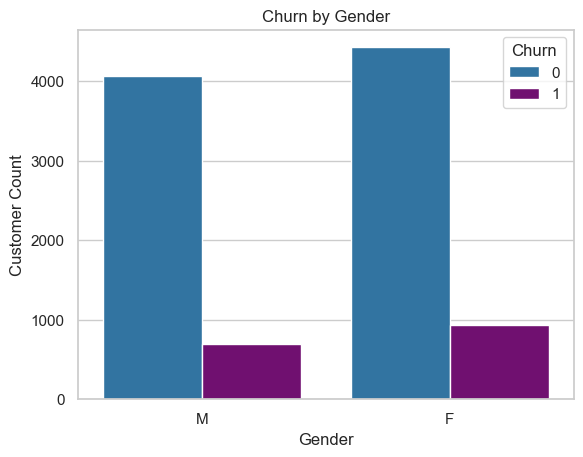

In [94]:
sns.countplot(x='Gender', hue='Churn', data=bchurners, palette={0: "#1f77b4", 1: "#800080"})
plt.title('Churn by Gender')
plt.ylabel('Customer Count')
plt.xlabel('Gender')
plt.show()

The gender distribution in the dataset appears fairly balanced, with slightly more female customers than male. Both groups show a similar pattern in churn, with female customers exhibiting a slightly higher absolute churn count. However, this difference is modest and may be explained by the slightly larger population of female customers overall.
The churn bars for both genders are relatively close in height, indicating that gender does not appear to be a strong differentiator in churn behaviour within this dataset. While female customers show a marginally higher attrition count, it is not likely to be statistically significant without further proportion-based analysis.
In summary, gender may not be a key driver of churn on its own, but it remains useful as part of a broader customer segmentation strategy — particularly when combined with other demographic or behavioural features such as income, card usage, or tenure. Calculating churn rate by gender could help confirm whether the small difference seen here is meaningful.

## **Modelling**
- Logistic Regression,apply SMOTE after this
- Random Forest 
- XGBoost 
- Cross-validation & AUC
- Feature importance

In [99]:
X = bchurners_encoded.drop(['Churn'], axis=1)
y = bchurners_encoded['Churn']


array([[<Axes: title={'center': 'Customer_Age'}>,
        <Axes: title={'center': 'Dependent_count'}>,
        <Axes: title={'center': 'Months_on_book'}>,
        <Axes: title={'center': 'Total_Relationship_Count'}>],
       [<Axes: title={'center': 'Months_Inactive_12_mon'}>,
        <Axes: title={'center': 'Contacts_Count_12_mon'}>,
        <Axes: title={'center': 'Credit_Limit'}>,
        <Axes: title={'center': 'Total_Revolving_Bal'}>],
       [<Axes: title={'center': 'Avg_Open_To_Buy'}>,
        <Axes: title={'center': 'Total_Amt_Chng_Q4_Q1'}>,
        <Axes: title={'center': 'Total_Trans_Amt'}>,
        <Axes: title={'center': 'Total_Trans_Ct'}>],
       [<Axes: title={'center': 'Total_Ct_Chng_Q4_Q1'}>,
        <Axes: title={'center': 'Avg_Utilization_Ratio'}>, <Axes: >,
        <Axes: >]], dtype=object)

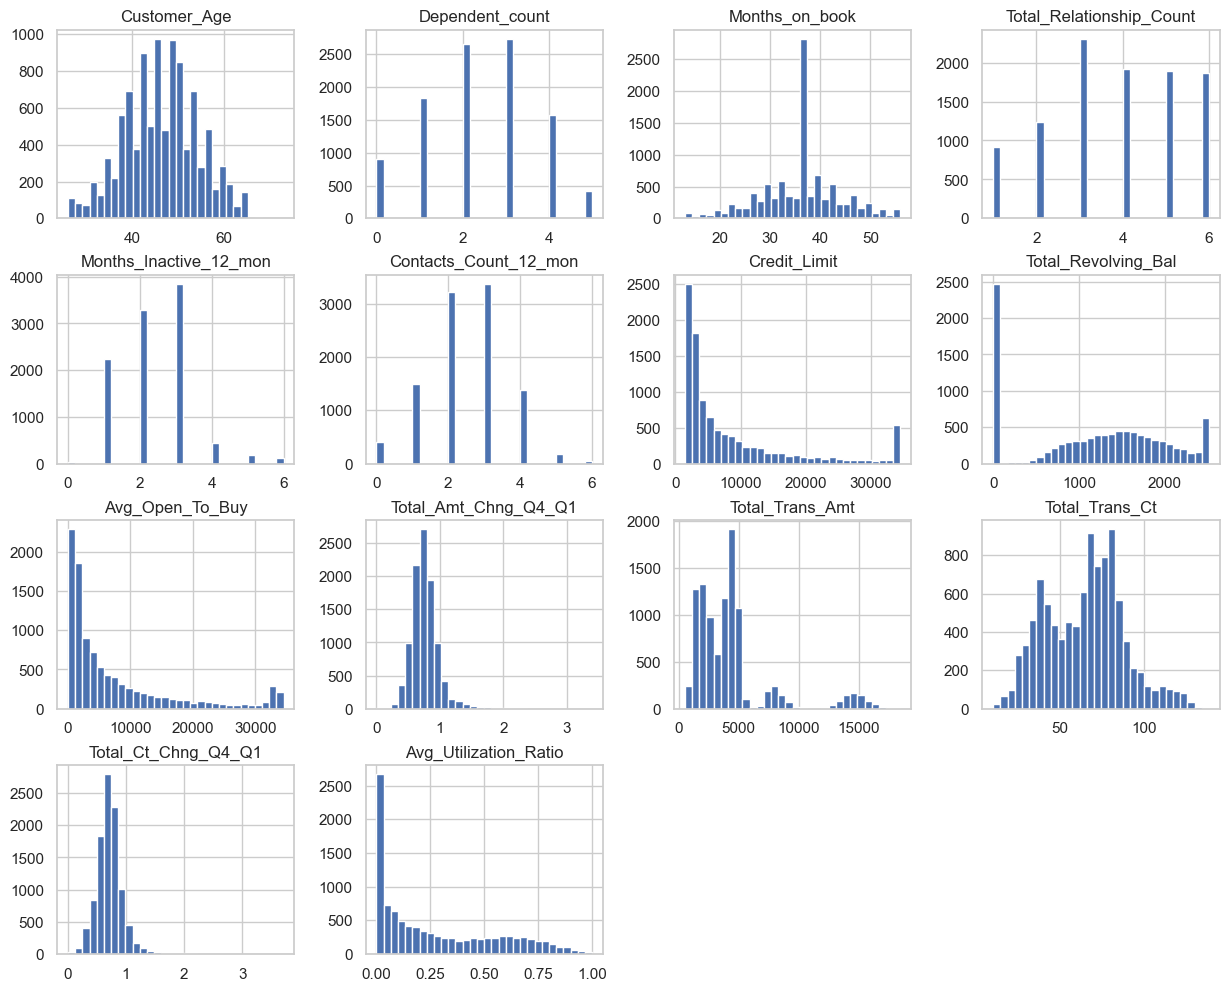

In [100]:
#visualising the ditsributtion of all variables to know how and when to  address outliers
X[numerical_cols].hist(figsize=(15, 12), bins=30)


> Several features are right-skewed with heavy tails: Credit_Limit, Avg_Open_To_Buy, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio
> A few variables like Total_Trans_Ct and Customer_Age are closer to normal distributions.
> Discrete features: Months_Inactive_12_mon, Contacts_Count_12_mon, Dependent_count, etc., show clearly defined values.
--------
**What to do?**
- Log Transform (skewed): Improves Logistic Regression, stabilises variance
- Keep Outliers: values seem real and meaningful
- Use SMOTE:Class imbalance is real (~16% churn)
- Keep raw values (for trees): Random Forest/XGBoost handle skew & outliers well



#### **1. Logistic Regression**

In [104]:
#Log Transformation to Skewed Features
# Columns to log-transform (right-skewed)
cols_to_log = [
    'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt',
    'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1'
]

# Apply log(1 + x) to avoid log(0) errors
for col in cols_to_log:
    bchurners_encoded[f'{col}_log'] = np.log1p(bchurners_encoded[col])

In [106]:
#Update Feature Set
# Drop the original versions of the transformed columns
X = bchurners_encoded.drop(['Churn'] + cols_to_log, axis=1)
y = bchurners_encoded['Churn']


In [107]:
#Train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [108]:
#Apply SMOTE ti Training Set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [109]:
# Run logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train_resampled)
y_pred = logreg.predict(X_test_scaled)

print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred, target_names=['Existing', 'Attrited']))


Logistic Regression Report:

              precision    recall  f1-score   support

    Existing       0.93      0.95      0.94      2551
    Attrited       0.70      0.64      0.67       488

    accuracy                           0.90      3039
   macro avg       0.81      0.79      0.80      3039
weighted avg       0.89      0.90      0.90      3039



**View Top 10 Predictors (Feature Importance) - Logistic Regression**

In [111]:
# Get feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
})

# Sort by absolute importance
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
top_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 predictors
top_features[['Feature', 'Coefficient']].head(10)

,Feature,Coefficient
7,Total_Trans_Ct,-4.157473
29,Total_Trans_Amt_log,2.603270
28,Avg_Open_To_Buy_log,-2.076224
27,Credit_Limit_log,1.477783
22,Income_Category_Less than $40K,1.471951
8,Avg_Utilization_Ratio,-1.271639
17,Marital_Status_Single,1.161174
11,Education_Level_Graduate,1.019626
12,Education_Level_High School,0.959617
23,Income_Category_Unknown,0.955857


C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\2099003781.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


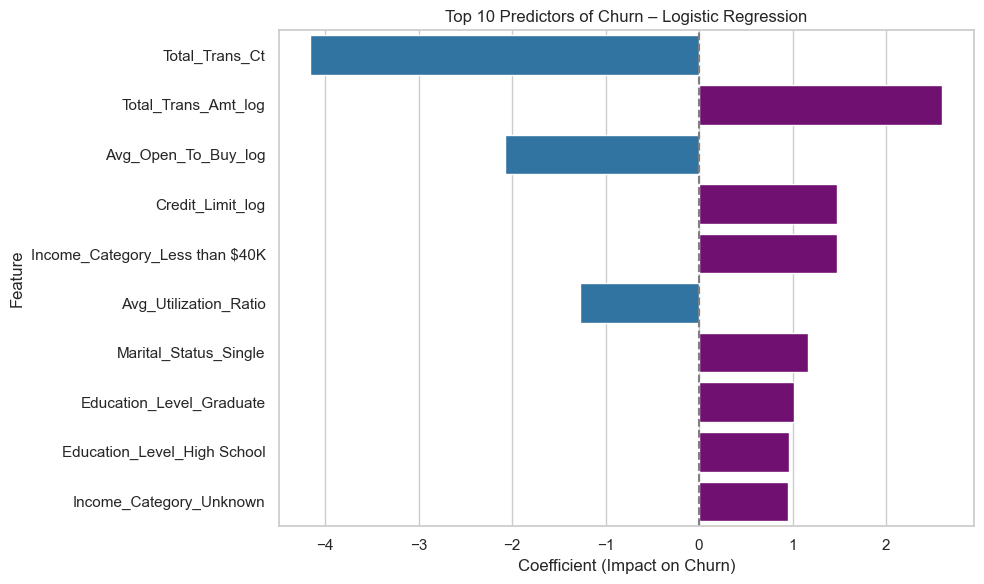

In [119]:
#visualise top 1o 
# Sort top predictors again if not already sorted
top_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=top_features,
    palette=['#800080' if coef > 0 else '#1f77b4' for coef in top_features['Coefficient']]
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Top 10 Predictors of Churn – Logistic Regression')
plt.xlabel('Coefficient (Impact on Churn)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

- Positive coefficients → increase likelihood of churn ( purple )
- Negative coefficients → reduce likelihood of churn -Blue
#### Key Insights:
- **`Total_Trans_Ct`** has the strongest negative impact, suggesting that customers with **higher transaction counts** are far less likely to churn.
- Features like **`Total_Trans_Amt_log`**, **`Credit_Limit_log`**, and **`Avg_Utilization_Ratio`** have positive coefficients, indicating they are associated with **higher churn risk**.
- Categorical indicators such as **`Income_Category_Less than USD40K`**, **`Marital_Status_Single`**, and **`Education_Level_High School`** also appear among the top predictors, showing some demographic and behavioural trends linked to attrition.

#### **Confusion Matrix for Logistic Regression**


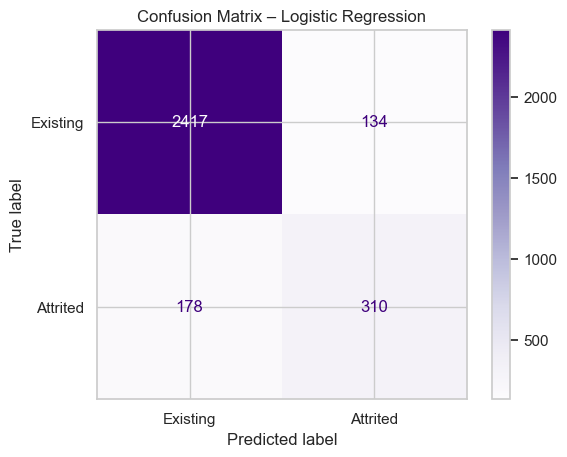

In [122]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(
    logreg,
    X_test_scaled,
    y_test,
    display_labels=['Existing', 'Attrited'],
    cmap='Purples'
)

plt.title("Confusion Matrix – Logistic Regression")
plt.show()


##### The confusion matrix provides a breakdown of the model's predictions on the test set:

|                  | Predicted Existing | Predicted Attrited |
|------------------|--------------------|---------------------|
| **Actual Existing** | 2,417 (True Negatives) | 134 (False Positives) |
| **Actual Attrited** | 178 (False Negatives) | 310 (True Positives) |

#### Interpretation:
- The model correctly identified **310 churned customers** and **2,417 retained customers**.
- There were **178 missed churners** (false negatives), and **134 customers were incorrectly predicted to churn** (false positives).
- This is a **strong performance**, especially considering class imbalance. Most importantly, the model captures a good number of churners (recall = 64%) without a high false alarm rate.

This matrix confirms the model’s balanced trade-off between identifying churn while maintaining accuracy with retained customers.

In [124]:
# Save logistic regression dataset with log-transformed columns
bchurners_encoded.to_csv("logistic_regression_prepared.csv", index=False)


In [126]:
#export just the features used in modelling
# Convert scaled data back to DataFrame if needed
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Reattach target if you want full training data with labels
X_scaled_df['Churn'] = y_train_resampled.reset_index(drop=True)

# Save it
X_scaled_df.to_csv("logreg_scaled_train_data.csv", index=False)

## New feature set for RF and XGBoost, excluding the log-transformed variables:
- These are tree-based models.
- They do not require scaling or log transformations.

### **2. Random Forest**

In [129]:
cols_to_log = [
    'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Trans_Amt',
    'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1'
]

# Drop log-transformed features
X_rf = bchurners_encoded.drop(['Churn'] + [f'{col}_log' for col in cols_to_log], axis=1)
y_rf = bchurners_encoded['Churn']


In [131]:
#Train-Test Split + SMOTE 
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf
)

# SMOTE to balance classes
smote = SMOTE(random_state=42)
X_rf_train_resampled, y_rf_train_resampled = smote.fit_resample(X_rf_train, y_rf_train)


In [132]:
#Train the Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_rf_train_resampled, y_rf_train_resampled)

RandomForestClassifier(random_state=42)

In [134]:
#predict and evaluate
y_rf_pred = rf.predict(X_rf_test)

print("Random Forest Classification Report:\n")
print(classification_report(y_rf_test, y_rf_pred, target_names=['Existing', 'Attrited']))

Random Forest Classification Report:

              precision    recall  f1-score   support

    Existing       0.97      0.97      0.97      2551
    Attrited       0.84      0.86      0.85       488

    accuracy                           0.95      3039
   macro avg       0.91      0.91      0.91      3039
weighted avg       0.95      0.95      0.95      3039



#### **Confusion Matrix for Random Forrest**

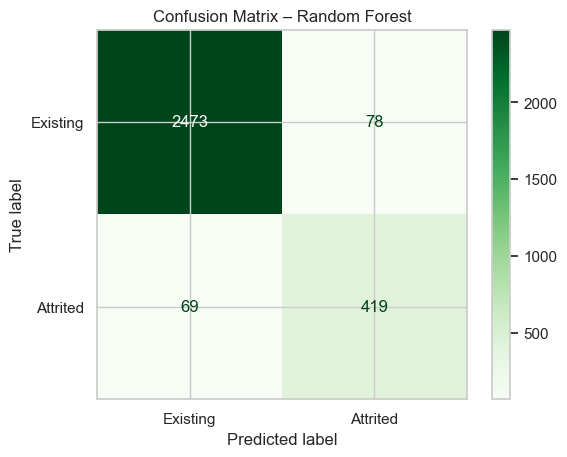

In [136]:
ConfusionMatrixDisplay.from_estimator(
    rf, X_rf_test, y_rf_test,
    display_labels=['Existing', 'Attrited'],
    cmap='Greens'
)
plt.title("Confusion Matrix – Random Forest")
plt.show()

#### **Random Forest – Performance Summary**

The Random Forest Classifier significantly outperformed Logistic Regression in both precision and recall for identifying churned customers.

| Metric      | Existing | Attrited |
|-------------|----------|----------|
| Precision   | 0.97     | 0.84     |
| Recall      | 0.97     | 0.86     |
| F1-score    | 0.97     | 0.85     |

- **Overall Accuracy:** 95%
- **Macro Avg F1-score:** 0.91  
- **Weighted Avg F1-score:** 0.95

####  CM Insights:
- Correctly predicted **419 churned customers** out of 488
- Only **69 churners missed** (false negatives)
- Very low false positives (78)

This performance highlights Random Forest’s strength in handling complex interactions and imbalanced data without needing scaling or transformation. It also suggests that churned customers exhibit patterns Random Forest can capture more effectively than a linear model.

#### ** Top 10 Predictors (Feature Importance) – Random Forest**
This shows which features were most influential in predicting churn:

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\57090874.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='Greens')


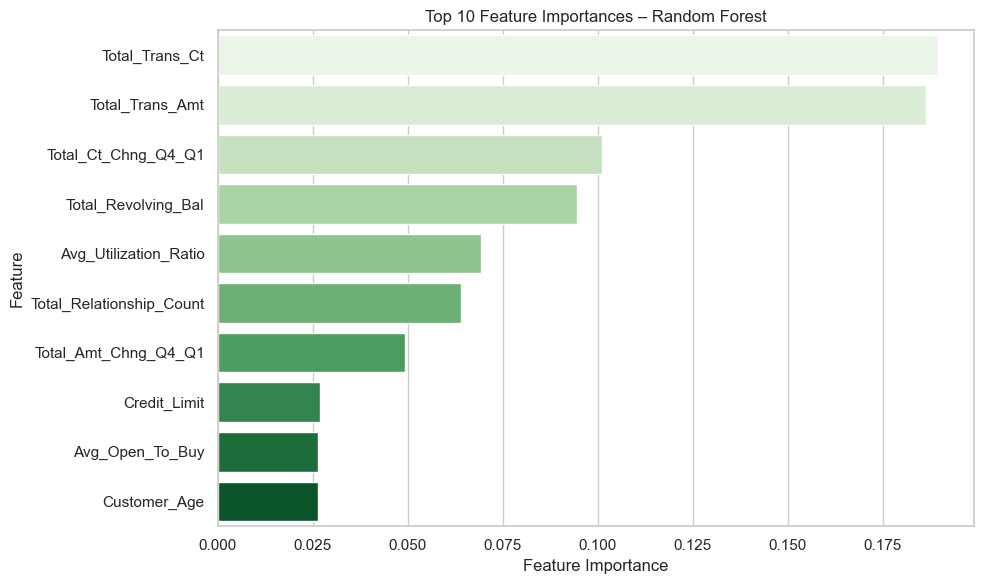

In [139]:
# Get feature importances and names
importances = rf.feature_importances_
features = X_rf.columns

# Create dataframe
rf_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='Greens')
plt.title('Top 10 Feature Importances – Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

The bar chart above shows the features that contributed most to the Random Forest model's ability to predict customer churn.

#### Insights:
- **`Total_Trans_Ct`** and **`Total_Trans_Amt`** are the strongest predictors of churn, indicating that **transaction volume and activity level** are critical behavioural signals.
- Change-based metrics like **`Total_Ct_Chng_Q4_Q1`** and **`Total_Amt_Chng_Q4_Q1`** are also highly informative — suggesting that **sudden drops or changes** in usage patterns may signal disengagement.
- **Balance metrics** like `Total_Revolving_Bal` and `Avg_Utilization_Ratio` also ranked highly, reinforcing the importance of **financial behaviour**.
- Demographics like `Customer_Age` appear less important compared to transactional features, further highlighting the strength of behavioural predictors in churn detection.

This aligns with what typically happens in this sector: customers who actively use their cards tend to stay, while a drop in transactions or usage patterns may precede attrition.


### Comparing Top Predictors: Logistic Regression vs. Random Forest

To better understand feature relevance across different models, we compare the top predictors identified by both **Logistic Regression** (based on coefficients) and **Random Forest** (based on feature importance).

#### Overlapping Predictors:
Both models consistently highlight key **behavioural features** as important:
- `Total_Trans_Ct` (Total Transaction Count)
- `Total_Trans_Amt` (Total Transaction Amount)
- `Avg_Utilization_Ratio` (Card Usage Ratio)
- `Credit_Limit` and `Avg_Open_To_Buy`

This agreement reinforces that **customer engagement and spending behaviour** are strong indicators of churn risk.

#### Differences:

| Logistic Regression                      | Random Forest                       |
|-----------------------------------------|-------------------------------------|
| Highlights categorical variables        | Prioritises continuous variables     |
| Sensitive to linear relationships       | Captures non-linear interactions    |
| Includes: `Income`, `Education`, `Marital_Status` | Focuses more on usage and trends |
| Uses log-transformed versions of some features | Uses raw numerical inputs          |

- Logistic Regression surfaced demographic features like `Income_Category_Less than USD40K`, `Education_Level_Graduate`, and `Marital_Status_Single`.
- Random Forest identified change-based behaviours like `Total_Ct_Chng_Q4_Q1` and `Total_Amt_Chng_Q4_Q1` as highly predictive — these were less influential in the linear model.


In [142]:
#saving RF dataset
# Combine X and y for saving
rf_dataset = X_rf.copy()
rf_dataset['Churn'] = y_rf

# Save to CSV
rf_dataset.to_csv("random_forest_dataset.csv", index=False)

### **3. XGBoost**


In [152]:
# Reuse from earlier
X_xgb = X_rf.copy()
y_xgb = y_rf.copy()

# Train-test split
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_xgb_train_resampled, y_xgb_train_resampled = smote.fit_resample(X_xgb_train, y_xgb_train)

In [154]:
#train the XGboost classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_xgb_train_resampled, y_xgb_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [155]:
#Predict and Evaluate
y_xgb_pred = xgb.predict(X_xgb_test)

print("XGBoost Classification Report:\n")
print(classification_report(y_xgb_test, y_xgb_pred, target_names=['Existing', 'Attrited']))


XGBoost Classification Report:

              precision    recall  f1-score   support

    Existing       0.98      0.98      0.98      1701
    Attrited       0.91      0.88      0.90       325

    accuracy                           0.97      2026
   macro avg       0.95      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



#### **Confusion Matrix for XGBoost**


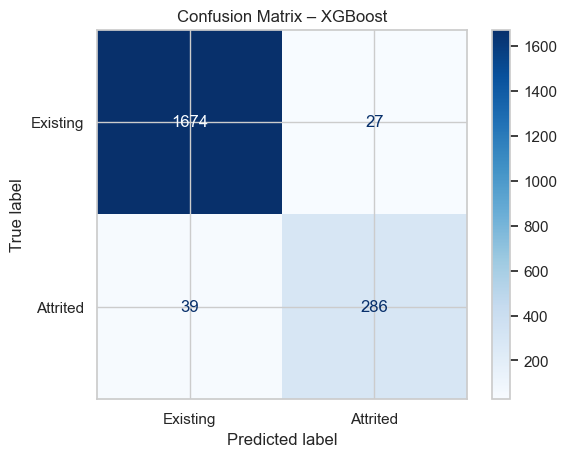

In [159]:
ConfusionMatrixDisplay.from_estimator(
    xgb, X_xgb_test, y_xgb_test,
    display_labels=['Existing', 'Attrited'],
    cmap='Blues'
)
plt.title("Confusion Matrix – XGBoost")
plt.show()


### **XGBoost – Performance Summary**

XGBoost delivered the highest performance among all models tested, showing strong capability in correctly identifying both churned and retained customers.

#### XGBoost Classification Report:

| Metric      | Existing | Attrited |
|-------------|----------|----------|
| Precision   | 0.98     | 0.91     |
| Recall      | 0.98     | 0.88     |
| F1-score    | 0.98     | 0.90     |

- **Overall Accuracy:** 97%
- **Macro Avg F1-score:** 0.94  
- **Weighted Avg F1-score:** 0.97

#### CM Insights:
- Correctly predicted **286 churned customers** out of 325 (88% recall)
- Very few false positives (**27**) and false negatives (**39**)

This is a **well-balanced model** with both **high precision** and **high recall**, making it an excellent choice for churn prediction where missing churners is costly.

**XGBoost's ability to model complex relationships and handle class imbalance makes it the top performer on this dataset so far.**


### ** Top 10 Predictors (Feature Importance) from XGBoost**

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\440878410.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='Blues_r')


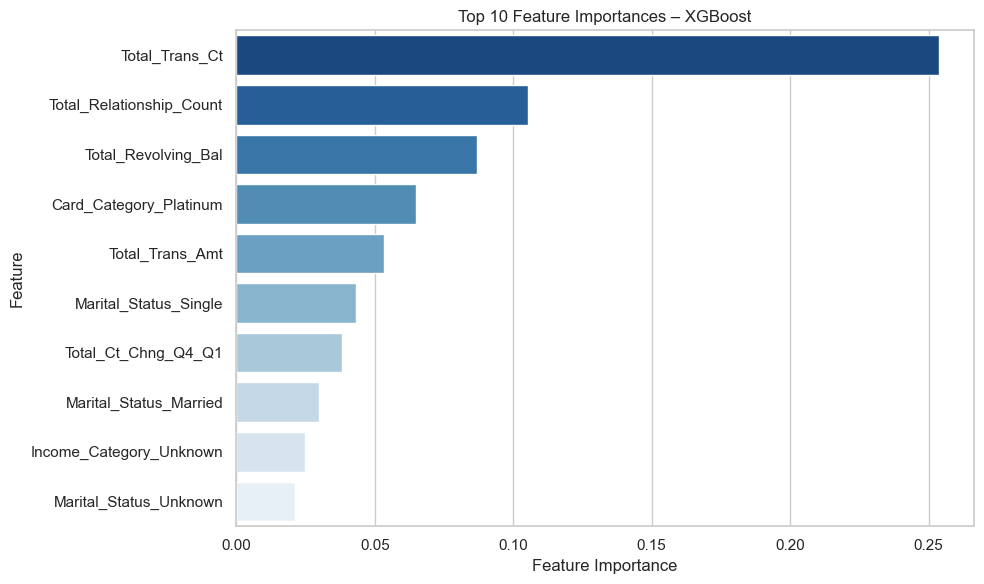

In [163]:
# Get feature importances and their names
xgb_importances = xgb.feature_importances_
features = X_xgb.columns

# Create DataFrame and get top 10
xgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='Blues_r')
plt.title('Top 10 Feature Importances – XGBoost')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()



The chart above displays the most influential features used by the XGBoost model to predict customer churn.

####  Key Observations:

- **`Total_Trans_Ct`** (Total Transaction Count) is by far the most important feature.  
  This indicates that **high activity levels** are strongly associated with customer retention.
- **`Total_Relationship_Count`** and **`Total_Revolving_Bal`** also play a significant role, suggesting that **broader engagement with the bank** and **available credit balance usage** are meaningful churn signals.
- Surprisingly, **`Card_Category_Platinum`** is ranked 4th, indicating that card type (though rare) might be tied to specific patterns or service expectations leading to churn.

- Other high-value features include:
  - **`Total_Trans_Amt`** (transaction amount),
  - **`Total_Ct_Chng_Q4_Q1`** (change in transaction count),
  - and **`Marital_Status_Single/Married/Unknown`**, showing demographic links to behaviour.
- **`Income_Category_Unknown`** also appears, possibly flagging profiles with insufficient financial data.


XGBoost relies heavily on **behavioural engagement metrics** and **card/relationship patterns**, more than demographic attributes, reinforcing earlier findings from Random Forest.

These features can now inform both:
- **Retention strategies**, and
- **Interactive Power BI dashboards** (e.g., segmenting at-risk customers by transaction activity or relationship breadth).


In [165]:
# Combine X and y for saving
xgb_dataset = X_xgb.copy()
xgb_dataset['Churn'] = y_xgb

# Save to CSV
xgb_dataset.to_csv("xgboost_dataset.csv", index=False)


## **Visualise Feature Comparison Across Models**

In [169]:
# Build the comparison table
feature_ranking = pd.DataFrame({
    'Rank': list(range(1, 11)),
    'Logistic Regression': [
        'Total_Trans_Ct', 'Total_Trans_Amt_log', 'Avg_Open_To_Buy_log', 'Credit_Limit_log',
        'Income_Category_Less than $40K', 'Avg_Utilization_Ratio', 'Marital_Status_Single',
        'Education_Level_Graduate', 'Education_Level_High School', 'Income_Category_Unknown'
    ],
    'Random Forest': [
        'Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal',
        'Avg_Utilization_Ratio', 'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1',
        'Credit_Limit', 'Avg_Open_To_Buy', 'Customer_Age'
    ],
    'XGBoost': [
        'Total_Trans_Ct', 'Total_Relationship_Count', 'Total_Revolving_Bal', 'Card_Category_Platinum',
        'Total_Trans_Amt', 'Marital_Status_Single', 'Total_Ct_Chng_Q4_Q1',
        'Marital_Status_Married', 'Income_Category_Unknown', 'Marital_Status_Unknown'
    ]
})

In [171]:
# Reshape 
df_melted = feature_ranking.melt(id_vars='Rank', var_name='Model', value_name='Feature')

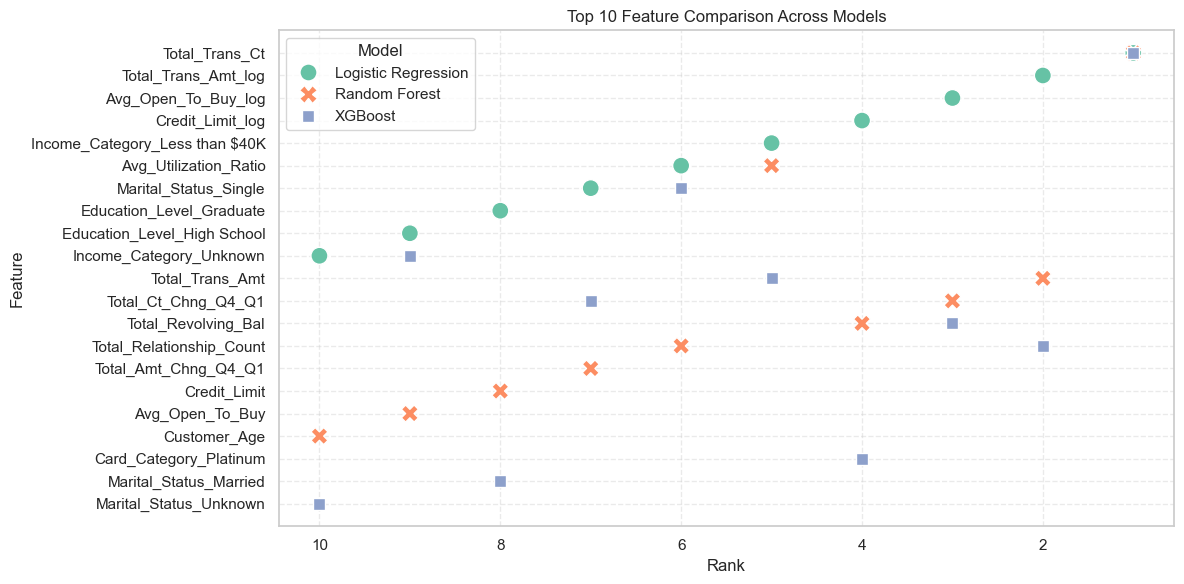

In [173]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_melted,
    x='Rank', y='Feature', hue='Model', s=150, palette='Set2', style='Model'
)
plt.title("Top 10 Feature Comparison Across Models")
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Feature Rank Heatmap Across Models**

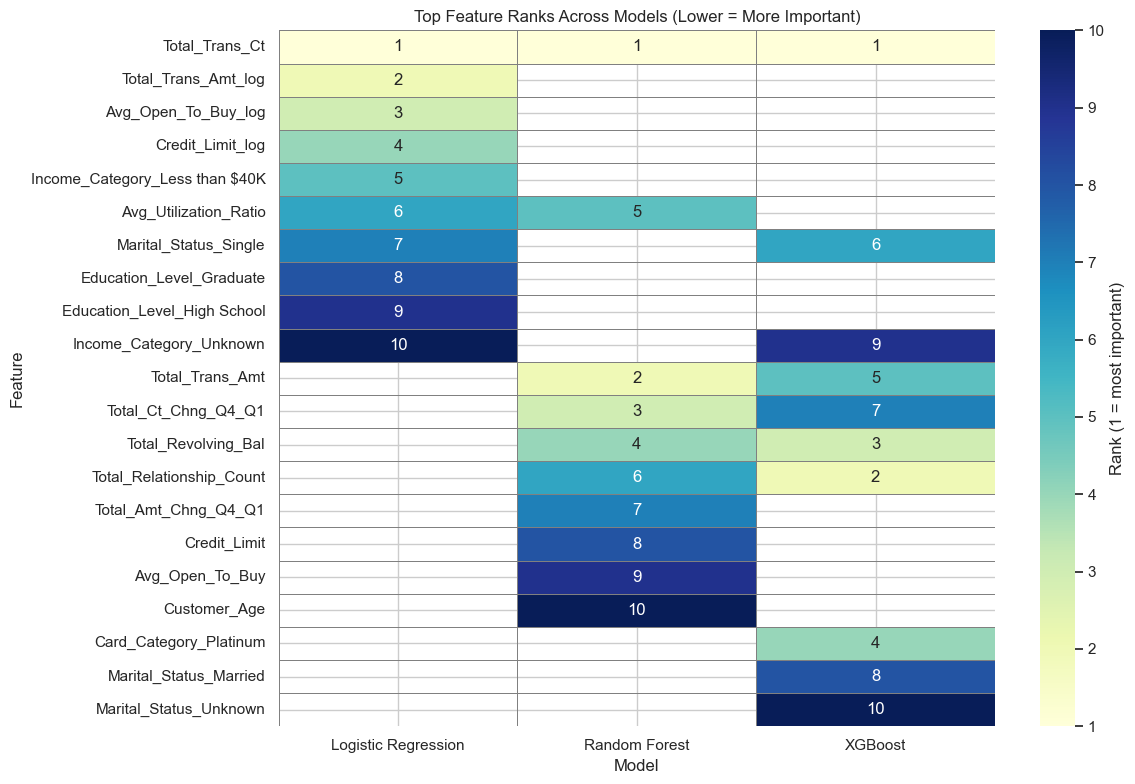

In [176]:
# Raw dictionary to build the heatmap
rank_data = {
    'Total_Trans_Ct':           {'Logistic Regression': 1, 'Random Forest': 1, 'XGBoost': 1},
    'Total_Trans_Amt_log':      {'Logistic Regression': 2},
    'Avg_Open_To_Buy_log':      {'Logistic Regression': 3},
    'Credit_Limit_log':         {'Logistic Regression': 4},
    'Income_Category_Less than $40K': {'Logistic Regression': 5},
    'Avg_Utilization_Ratio':    {'Logistic Regression': 6, 'Random Forest': 5},
    'Marital_Status_Single':    {'Logistic Regression': 7, 'XGBoost': 6},
    'Education_Level_Graduate': {'Logistic Regression': 8},
    'Education_Level_High School': {'Logistic Regression': 9},
    'Income_Category_Unknown':  {'Logistic Regression': 10, 'XGBoost': 9},
    'Total_Trans_Amt':          {'Random Forest': 2, 'XGBoost': 5},
    'Total_Ct_Chng_Q4_Q1':      {'Random Forest': 3, 'XGBoost': 7},
    'Total_Revolving_Bal':      {'Random Forest': 4, 'XGBoost': 3},
    'Total_Relationship_Count': {'Random Forest': 6, 'XGBoost': 2},
    'Total_Amt_Chng_Q4_Q1':     {'Random Forest': 7},
    'Credit_Limit':             {'Random Forest': 8},
    'Avg_Open_To_Buy':          {'Random Forest': 9},
    'Customer_Age':             {'Random Forest': 10},
    'Card_Category_Platinum':   {'XGBoost': 4},
    'Marital_Status_Married':   {'XGBoost': 8},
    'Marital_Status_Unknown':   {'XGBoost': 10}
}

# Convert to DataFrame
heatmap_df = pd.DataFrame(rank_data).T.fillna(0)

# Invert ranks for heatmap (lower rank = darker colour)
heatmap_display = heatmap_df.replace(0, np.nan)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_display,
    annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, linecolor='gray',
    cbar_kws={"label": "Rank (1 = most important)"}
)
plt.title("Top Feature Ranks Across Models (Lower = More Important)")
plt.ylabel("Feature")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


The heatmap above illustrates how each model ranked its top 10 features for predicting customer churn. A **lower rank (1)** indicates **higher importance** in that model’s decision-making process.

#### Key Takeaways:

- **`Total_Trans_Ct`** is ranked **#1** across all three models — making it the most powerful and consistent churn predictor.
  
- **Behavioural indicators dominate** Random Forest and XGBoost:
  - `Total_Trans_Amt`, `Total_Revolving_Bal`, `Total_Ct_Chng_Q4_Q1`, and `Total_Relationship_Count` appear frequently with high importance.
  - These models capture nuanced spending and engagement behaviour better than linear models.

- **Logistic Regression leans heavily on demographic & encoded categories**:
  - Variables like `Income_Category_Less than $40K`, `Education_Level_Graduate`, and `Marital_Status_Single` appear prominently.
  - This is likely due to how one-hot encoded variables carry weight in linear models.

- **Some features are unique to specific models**:
  - XGBoost highlights variables like `Card_Category_Platinum` and `Marital_Status_Unknown` — potentially due to its ability to model interactions.
  - Logistic Regression includes more label-encoded categories that do not appear in the others.

#### for Stakeholders:

This comparison helps stakeholders understand:
- Which features consistently drive churn across models.
- Where advanced models uncover deeper patterns beyond demographics.
- How to prioritise features when building visual dashboards or deploying models in production.

## **5-Fold Cross-Validation with AUC for XGBoost (better performer)**

In [179]:
# Define model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(xgb_model, X_xgb, y_xgb, scoring='roc_auc', cv=cv)

# Output
print("AUC scores per fold:", auc_scores)
print("Average AUC score: {:.4f}".format(auc_scores.mean()))

AUC scores per fold: [0.98998376 0.99474377 0.99018462 0.99273303 0.99573756]
Average AUC score: 0.9927


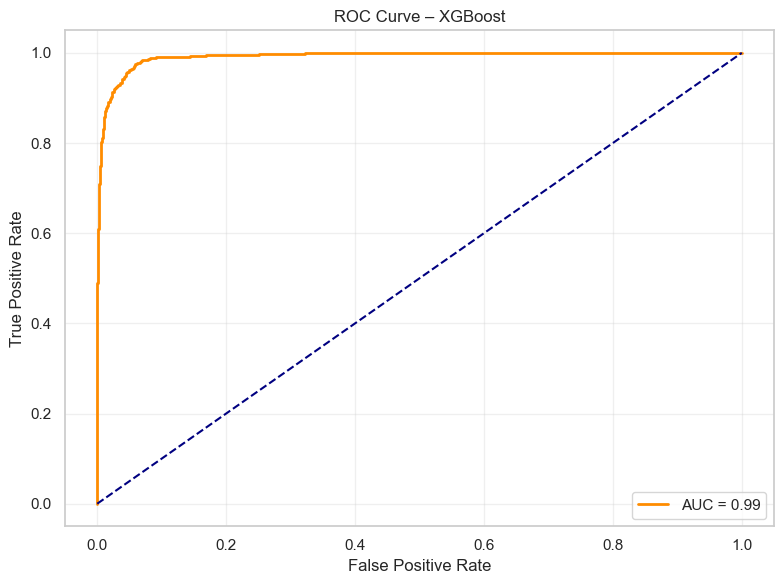

In [180]:
# Train model on train set
xgb_model.fit(X_train, y_train)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve – XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


AUC = 0.99
→ This means there's a 99% chance that the model will correctly rank a randomly chosen attrited customer higher than a randomly chosen existing customer in terms of churn probability.
The curve hugs the top-left corner
→ This suggests excellent performance: high sensitivity (recall) and low false positive rate.
The dashed diagonal line
→ Represents a random classifier (AUC = 0.5) — your model far outperforms it.



## **Plot Correlation Heatmap of Features**
- Detect multicollinearity (strongly related predictors)
- Simplify the model by removing or combining redundant variables

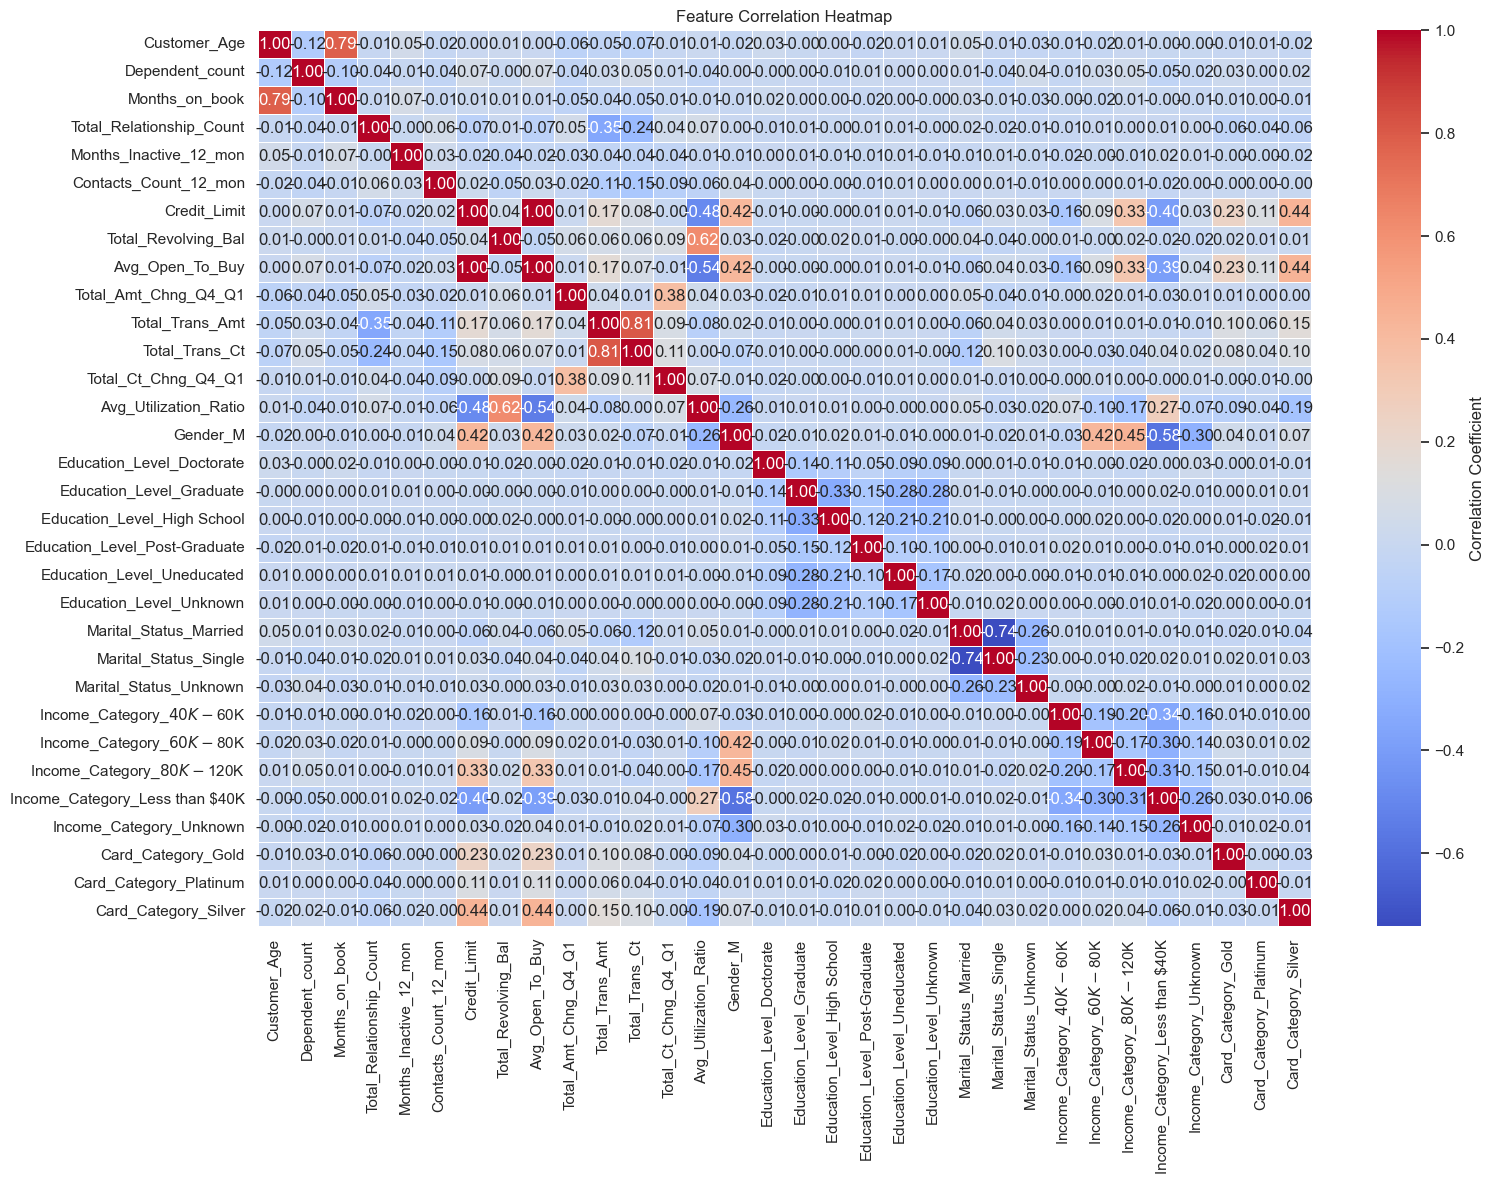

In [184]:
# Compute correlation matrix
corr_matrix = X_xgb.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


## **Filtered Heatmap (|correlation| ≥ 0.5)**


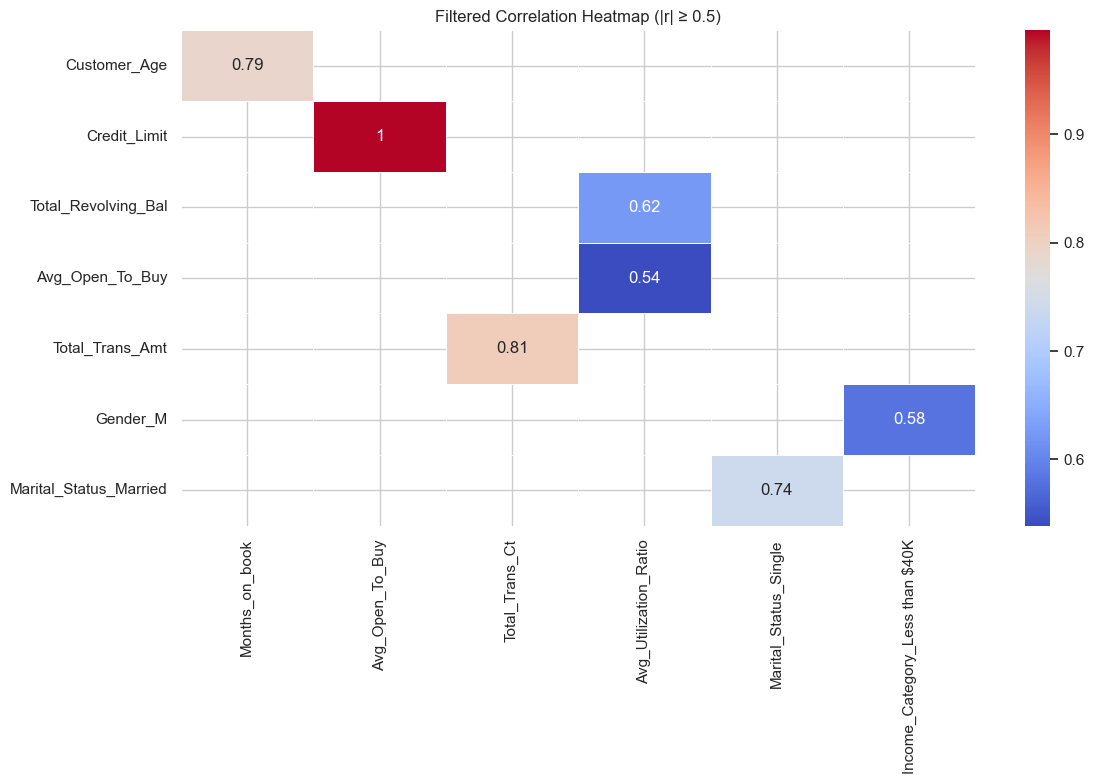

In [186]:
# Compute correlation matrix
corr_matrix = X_xgb.corr().abs()

# Filter for values ≥ 0.6 and remove self-correlations (diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
high_corr = corr_matrix.where(mask)
filtered_corr = high_corr[(high_corr >= 0.5) & (high_corr < 1.0)]

# Drop empty rows and columns
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Correlation Heatmap (|r| ≥ 0.5)')
plt.tight_layout()
plt.show()

## **List of Top Correlated Pairs**

In [188]:
# Extract top correlated pairs (|r| ≥ 0.5)
top_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
top_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
top_pairs = top_pairs[top_pairs['Correlation'] >= 0.5].sort_values(by='Correlation', ascending=False)

# Display
from IPython.display import display
display(top_pairs)

,Feature 1,Feature 2,Correlation
172,Credit_Limit,Avg_Open_To_Buy,0.995981
265,Total_Trans_Amt,Total_Trans_Ct,0.807192
1,Customer_Age,Months_on_book,0.788912
441,Marital_Status_Married,Marital_Status_Single,0.741185
201,Total_Revolving_Bal,Avg_Utilization_Ratio,0.624022
355,Gender_M,Income_Category_Less than $40K,0.580016
224,Avg_Open_To_Buy,Avg_Utilization_Ratio,0.538808


### **Drop and Create New Features**

In [190]:
#drop
X_xgb = X_xgb.drop(columns=['Avg_Open_To_Buy'])
#Create
X_xgb['Revolving_Bal_Per_Limit'] = X_xgb['Total_Revolving_Bal'] / X_xgb['Credit_Limit']
X_xgb['Avg_Transaction_Value'] = X_xgb['Total_Trans_Amt'] / X_xgb['Total_Trans_Ct']


In [192]:
# Assuming your updated dataframe is named X_xgb and you have the target column 'Churn'
updated_dataset = X_xgb.copy()
updated_dataset['Churn'] = y_xgb  # Add the target column back if needed

# Save to CSV (in your local working directory)
updated_dataset.to_csv("XGBoost_dataset_updated.csv", index=False)

## **Modelling After Feature Selection**

In [194]:
# Load the Excel file
XGBoost_df = pd.read_csv("XGBoost_dataset_updated.csv")

# Preview the first few rows
XGBoost_df.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Revolving_Bal_Per_Limit,Avg_Transaction_Value,Churn
0,45,3,39,5,1,3,12691.0,777,1.335,1144,...,True,False,False,False,False,False,False,0.061224,27.238095,0
1,49,5,44,6,1,2,8256.0,864,1.541,1291,...,False,False,True,False,False,False,False,0.104651,39.121212,0
2,51,3,36,4,1,0,3418.0,0,2.594,1887,...,False,True,False,False,False,False,False,0.000000,94.350000,0
3,40,4,34,3,4,1,3313.0,2517,1.405,1171,...,False,False,True,False,False,False,False,0.759734,58.550000,0
4,40,3,21,5,1,0,4716.0,0,2.175,816,...,True,False,False,False,False,False,False,0.000000,29.142857,0


In [195]:
# Define features and target
X_xgb = XGBoost_df.drop(columns=['Churn'])
y_xgb = XGBoost_df['Churn']


In [197]:
#Train-Test Split + SMOTE
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Train the XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **Evaluate Performance**

XGBoost Classification Report (Updated Features):

              precision    recall  f1-score   support

    Existing       0.98      0.98      0.98      1701
    Attrited       0.91      0.88      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



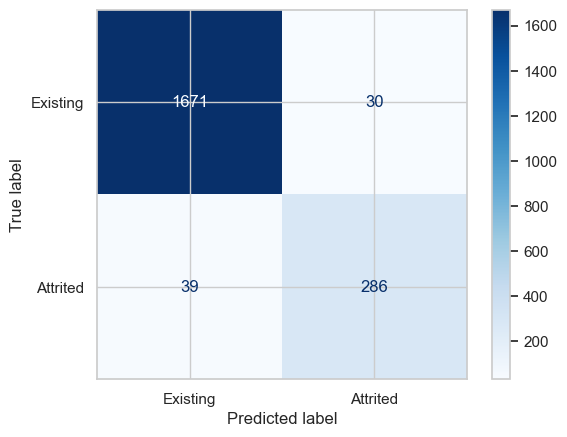

In [199]:
# Predict
y_pred = xgb_model.predict(X_test)

# Classification report
print("XGBoost Classification Report (Updated Features):\n")
print(classification_report(y_test, y_pred, target_names=['Existing', 'Attrited']))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    xgb_model, X_test, y_test,
    display_labels=['Existing', 'Attrited'],
    cmap='Blues'
)

C:\Users\gochi\AppData\Local\Temp\ipykernel_22600\3034799603.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_d")


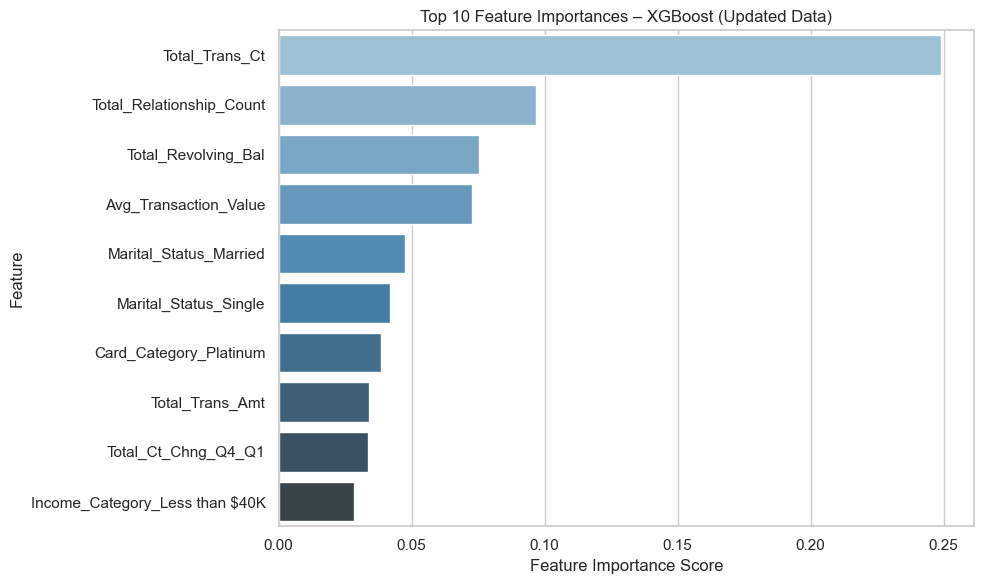

In [200]:
# Get feature importances from the trained XGBoost model
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_xgb.columns)

# Sort and select top 10
top_features = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_d")
plt.title("Top 10 Feature Importances – XGBoost (Updated Data)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




After updating the dataset by removing highly correlated features and engineering new variables, the XGBoost model was retrained and revealed the following top predictors of churn:
1. Total_Trans_Ct – The strongest predictor. Fewer transactions often signal disengagement.
2. Total_Relationship_Count – Indicates the breadth of the customer’s engagement with the bank.
3. Total_Revolving_Bal – High revolving balances may reflect financial stress.
4. Avg_Transaction_Value – Newly engineered feature offering stronger granularity on spending behaviour.
5. Marital_Status_Married – Married customers may show different engagement or loyalty patterns.
6. Marital_Status_Single – In contrast to married status; suggests social demographics play a role.
7. Card_Category_Platinum – Premium card holders are more likely to churn if expectations aren’t met.
8. Total_Trans_Amt – Total amount spent is still relevant, though not as influential as frequency.
9. Total_Ct_Chng_Q4_Q1 – Reflects behavioural change over time, important for churn prediction.
10. Income_Category_Less than USD40K – Lower-income customers may churn due to cost sensitivity or dissatisfaction.

The refined model highlights behavioural activity (transactions) and engagement breadth (relationship count) as the clearest churn signals. Demographic and product-level features still play meaningful secondary roles.



## **Final Model Performance – XGBoost (After Feature Updates)**
>After cleaning, feature engineering, and filtering highly correlated variables, XGBoost was retrained using the updated dataset. The model shows outstanding performance:

- Accuracy: 97%
- Precision (Attrited): 0.91
- Recall (Attrited): 0.88
- F1-Score (Attrited): 0.89

###### These metrics reflect a strong ability to detect churners without sacrificing precision.

====The confusion matrix shows:

- True Positives (Churners correctly identified): 286
- False Positives (Non-churners incorrectly flagged): 30
- False Negatives (Churners missed): 39
- True Negatives: 1671

This confirms that the model generalises well and is ready for deployment, interpretation, and dashboard integration.

# **SHAP Model Interpretation Plan:**

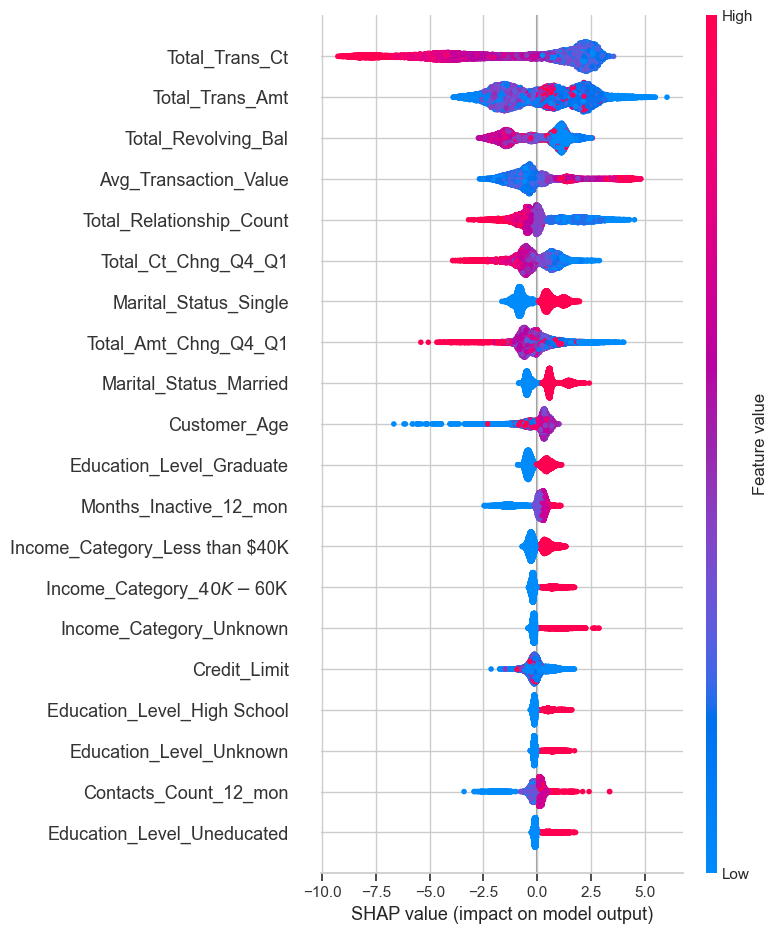

In [204]:
# 1. Initialise explainer
explainer = shap.Explainer(xgb_model)

# 2. Calculate SHAP values
shap_values = explainer(X_train_resampled)

# 3. Visualise
shap.summary_plot(shap_values, X_train_resampled)


#### Key Insights:
1. More Transactions = Less Churn:
Customers with higher Total_Trans_Ct (shown in red) generally push predictions toward retention (left side, negative SHAP values).

2. Lower Spending Patterns = Red Flag:
Lower Total_Trans_Amt and Avg_Transaction_Value (blue points) increase churn risk.

3. High Revolving Balances = Risky:
Higher Total_Revolving_Bal tends to push the model toward churn (positive SHAP).

4. Marital Status Matters:
Being Single (red on right) slightly increases churn, while being Married (blue on left) slightly reduces it.

5. Education and Income Levels:
Graduate education and low income are slightly associated with churn — possibly due to expectations vs experience or product mismatch.

In [217]:
#convert shap values into dataframe for PowerBI Visualisations
shap_df = pd.DataFrame(shap_values.values, columns=X_train_resampled.columns)

# Get mean absolute SHAP value per feature
shap_mean_values = shap_df.abs().mean().sort_values(ascending=False)

# Display the SHAP values in tabular form
print(shap_mean_values)

Total_Trans_Ct                    2.809375
Total_Trans_Amt                   1.597178
Total_Revolving_Bal               1.169870
Avg_Transaction_Value             0.974785
Total_Relationship_Count          0.906176
Total_Ct_Chng_Q4_Q1               0.767192
Marital_Status_Single             0.766372
Total_Amt_Chng_Q4_Q1              0.662095
Marital_Status_Married            0.633776
Customer_Age                      0.441404
Education_Level_Graduate          0.424397
Months_Inactive_12_mon            0.400274
Income_Category_Less than $40K    0.379440
Income_Category_$40K - $60K       0.343489
Income_Category_Unknown           0.304426
Credit_Limit                      0.295028
Education_Level_High School       0.267254
Education_Level_Unknown           0.260629
Contacts_Count_12_mon             0.244141
Education_Level_Uneducated        0.217656
Avg_Utilization_Ratio             0.213007
Marital_Status_Unknown            0.148259
Income_Category_$80K - $120K      0.132216
Months_on_b

In [219]:
#save to csv
shap_mean_values.to_csv('shap_feature_importances.csv', index=False)